In [1]:
# PACKAGES
import os
import numpy as np 
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import max_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, TimeDistributed, Bidirectional, ConvLSTM2D, Dropout
from tensorflow.keras.models import model_from_json

In [2]:
# parameters that can change
model_number = str()
learning_rate = 0.01
dropout_rate = 0
layer_size = 1
units = 1
activation_function = 'relu'
loss_function = 'mae'
epoch = 5
batch_size = 48
models = ['GRU','LSTM','SimpleRNN']
optimizers = 'Adam'

In [3]:
if optimizers == 'SGD':
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1)
elif optimizers == 'Adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1)
elif optimizers == 'Adamax':
    optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate, clipnorm=1)
elif optimizers == 'Adagrad':
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate, clipnorm=1)
elif optimizers == 'RMSprop':
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, clipnorm=1)
elif optimizers == 'Adadelta':
    optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate, clipnorm=1)
elif optimizers == 'Nadam':
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate, clipnorm=1)
elif optimizers == 'Ftrl':
    optimizer = tf.keras.optimizers.Ftrl(learning_rate=learning_rate, clipnorm=1)
# Unchanged parameters
return_sequence = True

SEED Set:  12345
(43033, 240) x (43033,) y
(30123, 24, 10) X_train.shape
(12910, 24, 10) X_test.shape
(30123,) y_train_df.shape
(12910,) y_test_df.shape
Training is starting


Epoch 1/5

628/628 [==============================] - 22s 30ms/step - loss: 0.1753 - val_loss: 0.1146
Epoch 2/5
628/628 [==============================] - 4s 7ms/step - loss: 0.1329 - val_loss: 0.0921
Epoch 3/5
628/628 [==============================] - 4s 7ms/step - loss: 0.1154 - val_loss: 0.0808
Epoch 4/5
628/628 [==============================] - 4s 7ms/step - loss: 0.1028 - val_loss: 0.0722
Epoch 5/5
628/628 [==============================] - 4s 7ms/step - loss: 0.0917 - val_loss: 0.0645
Duration: 0:00:48.173391
Training is finished. Model is being saved
404/404 [==============================] - 1s 3ms/step
y_pred_test shape (12910, 1)
942/942 [==============================] - 3s 3ms/step
inv_y_pred_train dtype:  float32
y_true_train dtype:  float64
inv_y_pred_test dtype:  float32
y_true_test dtype:  float

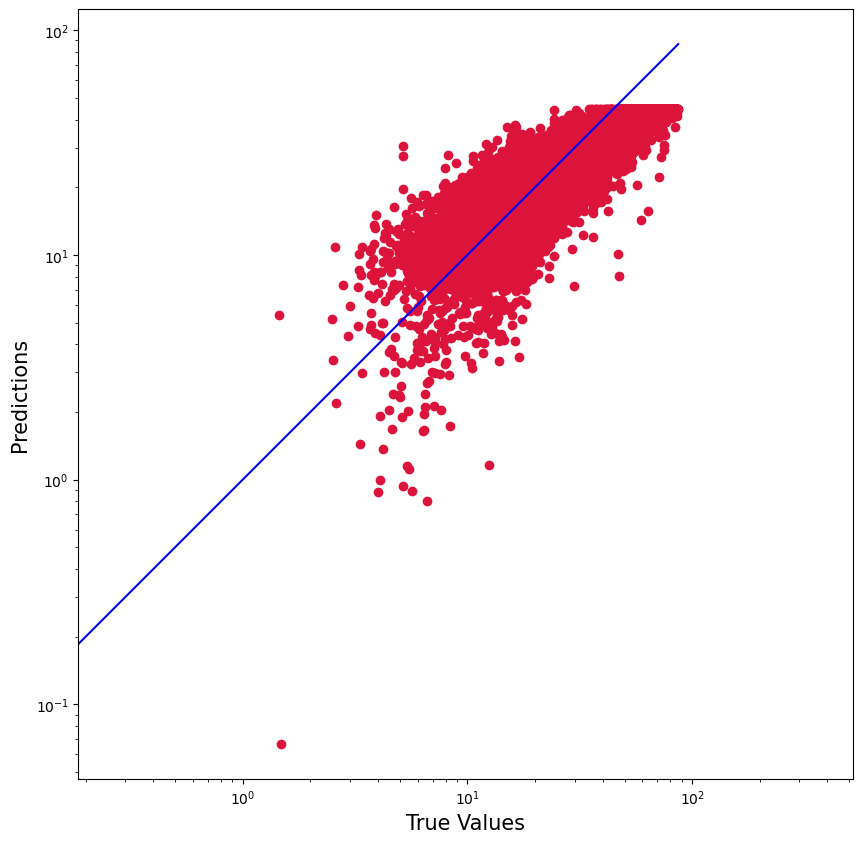

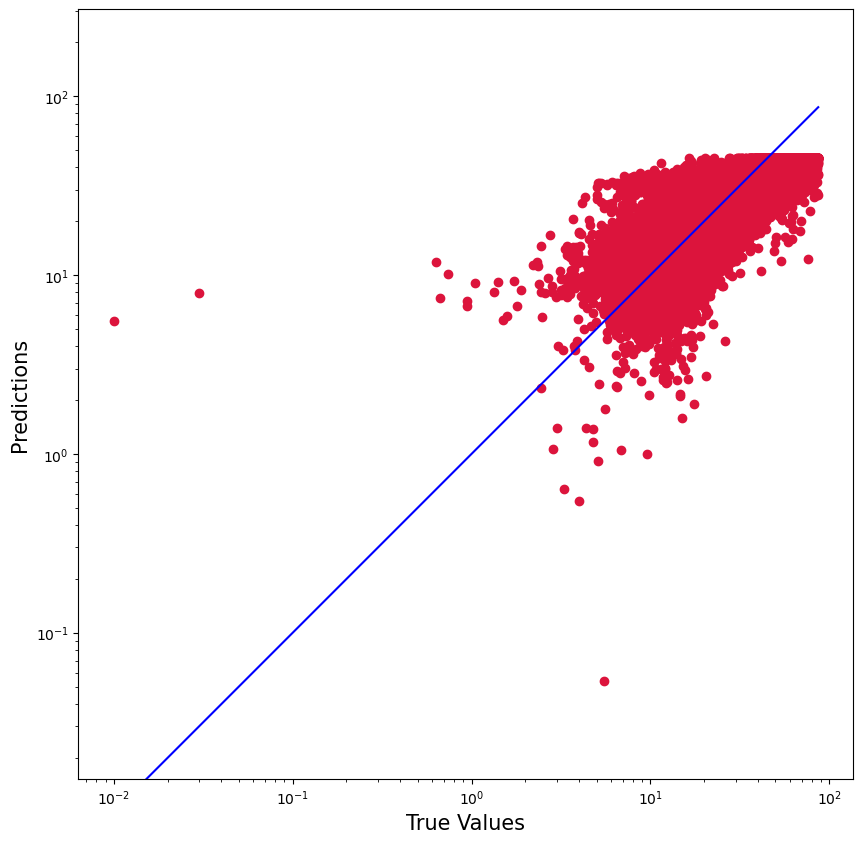

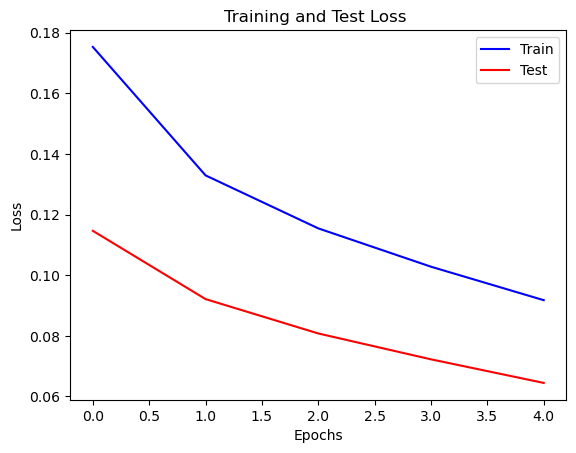

In [4]:
os.makedirs("images", exist_ok=True)
SEED = 12345
# Other Variables
target = 'PM2_5'
n_hours = 24
train_size = 0.7

# In order to produce the same results
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
print("SEED Set: ", SEED)

cols = [
    "PM2_5",
    "SO2",
    "NO",
    "NO2",
    "NOX",
    "O3",
    "wind_speed",
    "relative_humidity",
    "air_pressure",
]
cols_to_analyze = [
    "PM2_5",
    "SO2",
    "NO",
    "NO2",
    "NOX",
    "O3",
    "temperature",
    "wind_speed",
    "relative_humidity",
    "air_pressure",
]



# FUNCTIONS
def get_data(data_name_xlsx):
    raw_data = pd.read_excel(data_name_xlsx)
    raw_data['date'] = pd.to_datetime(raw_data['date'],
                                      format='%d.%m.%Y %H:%M')
    raw_data.index = raw_data['date']
    raw_data.drop('date', axis='columns', inplace=True)
    raw_data_2015 = raw_data.loc[raw_data.index >= pd.to_datetime(
        '01.01.2015 00:00', format='%d.%m.%Y %H:%M')]
    return raw_data_2015


def remove_outliers(dataset, cols):
    # Set the column values that are less than zero to 0.
    # Record zero values as missing data.
    dataset[cols] = dataset[cols].clip(lower=0)
    dataset[cols] = dataset[cols].replace(0, np.nan)
    # Make the wind variable categorical with NE: NorthEast
    #wind_categories = pd.cut(
    #    data.wind, bins=[-1, 90, 180, 270, 361], labels=["KD", "KB", "GB", "GD"])
    # data["wind_category"] = wind_categories
    # data.pop("wind")
    # dataset = pd.get_dummies(data, columns=["wind_category"])

    # Also save outliers as missing data.
    for col in cols:
        Q1 = dataset[col].quantile(0.25)
        Q3 = dataset[col].quantile(0.75)
        IQR = Q3 - Q1
        # print("col: {}, Q1: {}, Q3: {}, IQR: {}".format(col, Q1, Q3, IQR))
        ust_limit = Q3 + 3 * IQR
        alt_limit = Q1 - 3 * IQR
        # print("ust_limit: {}, alt_limit: {}".format(ust_limit, alt_limit))
        dataset.loc[dataset[col] >= ust_limit, col] = np.nan
        dataset.loc[dataset[col] <= alt_limit, col] = np.nan
    dataset = dataset.replace(-9999, np.nan)
    dataset['temperature'] = dataset['temperature'].replace(0, np.nan)
    return dataset


def impute_data(data):
    filled_data = data.interpolate(method='linear', axis=0).ffill().bfill()
    return filled_data


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df = pd.DataFrame(scaler.fit_transform(dataset),
                             index=dataset.index,
                             columns=dataset.columns)
    return scaler, scaled_df


def create_dataset(data_name_xlsx, cols, n_hours, target, train_size):
    """
    data_name_xlsx: Name of the Excel file
    cols: List of features
    n_hours: Number of hours of data to be used as input
    target: Feature to be predicted
    train_size: Training ratio
    """
    # load data
    raw_data = get_data(data_name_xlsx)
    # feature set
    raw_data = raw_data[cols]
    # remove outliers
    raw_data_missing = remove_outliers(raw_data, cols)
    # raw_data_missing.to_csv("raw_data_missing.csv")
    # Filling in missing data
    filled_data = impute_data(raw_data_missing)
    filled_data.to_csv("data/filled_data.csv")
    # scaling
    scaler, scaled_df = scale_data(filled_data)
    # Data framing
    reframed_df = pd.DataFrame(
        series_to_supervised(scaled_df.to_numpy(), n_hours, len([target])))
    # Columns to be dropped will go up to one less than the total number of features from the end.
    reframed_df = reframed_df.iloc[:, :-(len(cols) - 1)]
    reframed_df.index = filled_data.index[n_hours:]
    # reframed_df.to_csv("reframed.csv")
    # split_data
    X = reframed_df.iloc[:, :-1]
    y = reframed_df.iloc[:, -1]
    print(X.shape, "x", y.shape, "y")
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
        X, y, train_size=train_size, shuffle=False)
    X_train = X_train_df.to_numpy().reshape(
        (X_train_df.shape[0], n_hours, scaled_df.shape[1]))
    X_test = X_test_df.to_numpy().reshape(
        (X_test_df.shape[0], n_hours, scaled_df.shape[1]))
    print(X_train.shape, "X_train.shape")
    print(X_test.shape, "X_test.shape")
    print(y_train_df.shape, "y_train_df.shape")
    print(y_test_df.shape, "y_test_df.shape")
    return X_train, X_test, y_train_df, y_test_df


def fit_model(layer_size, X_train, X_test, y_train_df, batch_size, epoch,
              units, activation_function, loss_function, optimizer, layer):
    if not layer:
        raise ValueError("Layer list is empty. Please define the model architecture.")
    if layer_size == 1:  # 1 hidden layer exists
        model = Sequential()
        if layer[0] == 'GRU':
            model.add(
                GRU(units,
                    activation=activation_function,
                    input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(Dropout(dropout_rate))
        elif layer[0] == 'LSTM':
            model.add(
                LSTM(units,
                     activation=activation_function,
                     input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(Dropout(dropout_rate))
        elif layer[0] == 'SimpleRNN':
            model.add(
                SimpleRNN(units,
                          activation=activation_function,
                          input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(Dropout(dropout_rate))

    elif layer_size == 2:  # 2 hidden layer exists
        model = Sequential()
        first_layer = layer[0][0]
        second_layer = layer[0][1]
        if (first_layer == 'GRU') and (second_layer == 'GRU'):
            print("GRU GRU")
            model.add(
                GRU(units,
                    activation=activation_function,
                    input_shape=(X_train.shape[1], X_train.shape[2]),
                    return_sequences=True))
            model.add(Dropout(dropout_rate))
            model.add(GRU(units, activation=activation_function))
            model.add(Dropout(dropout_rate))
        elif (first_layer == 'LSTM') and (second_layer == 'LSTM'):
            model.add(
                LSTM(units,
                     activation=activation_function,
                     input_shape=(X_train.shape[1], X_train.shape[2]),
                     return_sequences=True))
            model.add(Dropout(dropout_rate))
            model.add(LSTM(units, activation=activation_function))
            model.add(Dropout(dropout_rate))
        elif (first_layer == 'SimpleRNN') and (second_layer == 'SimpleRNN'):
            model.add(
                SimpleRNN(units,
                          activation=activation_function,
                          input_shape=(X_train.shape[1], X_train.shape[2]),
                          return_sequences=True))
            model.add(Dropout(dropout_rate))
            model.add(SimpleRNN(units, activation=activation_function))
            model.add(Dropout(dropout_rate))
        elif (first_layer == 'GRU') and (second_layer == 'LSTM'):
            model.add(
                GRU(units,
                    activation=activation_function,
                    input_shape=(X_train.shape[1], X_train.shape[2]),
                    return_sequences=True))
            model.add(Dropout(dropout_rate))
            model.add(LSTM(units, activation=activation_function))
            model.add(Dropout(dropout_rate))
        elif (first_layer == 'GRU') and (second_layer == 'SimpleRNN'):
            model.add(
                GRU(units,
                    activation=activation_function,
                    input_shape=(X_train.shape[1], X_train.shape[2]),
                    return_sequences=True))
            model.add(Dropout(dropout_rate))
            model.add(SimpleRNN(units, activation=activation_function))
            model.add(Dropout(dropout_rate))
        elif (first_layer == 'LSTM') and (second_layer == 'SimpleRNN'):
            model.add(
                LSTM(units,
                     activation=activation_function,
                     input_shape=(X_train.shape[1], X_train.shape[2]),
                     return_sequences=True))
            model.add(Dropout(dropout_rate))
            model.add(SimpleRNN(units, activation=activation_function))
            model.add(Dropout(dropout_rate))
        elif (first_layer == 'LSTM') and (second_layer == 'GRU'):
            model.add(
                LSTM(units,
                     activation=activation_function,
                     input_shape=(X_train.shape[1], X_train.shape[2]),
                     return_sequences=True))
            model.add(Dropout(dropout_rate))
            model.add(GRU(units, activation=activation_function))
            model.add(Dropout(dropout_rate))
        elif (first_layer == 'SimpleRNN') and (second_layer == 'GRU'):
            model.add(
                SimpleRNN(units,
                          activation=activation_function,
                          input_shape=(X_train.shape[1], X_train.shape[2]),
                          return_sequences=True))
            model.add(Dropout(dropout_rate))
            model.add(GRU(units, activation=activation_function))
            model.add(Dropout(dropout_rate))
        elif (first_layer == 'SimpleRNN') and (second_layer == 'LSTM'):
            model.add(
                SimpleRNN(units,
                          activation=activation_function,
                          input_shape=(X_train.shape[1], X_train.shape[2]),
                          return_sequences=True))
            model.add(Dropout(dropout_rate))
            model.add(LSTM(units, activation=activation_function))
            model.add(Dropout(dropout_rate))

    else:  # 4 hidden layers exists
        model = Sequential()
        if layer[0] == 'GRU':
            model.add(
                GRU(units,
                    activation=activation_function,
                    input_shape=(X_train.shape[1], X_train.shape[2]),
                    return_sequences=True))
            model.add(Dropout(dropout_rate))
            model.add(GRU(units, activation=activation_function, return_sequences=True))
            model.add(GRU(units, activation=activation_function, return_sequences=True))
            model.add(GRU(units, activation=activation_function))
            model.add(Dropout(dropout_rate))
        elif layer[0] == 'LSTM':
            model.add(
                LSTM(units,
                     activation=activation_function,
                     input_shape=(X_train.shape[1], X_train.shape[2]),
                     return_sequences=True))
            model.add(Dropout(dropout_rate))
            model.add(LSTM(units, activation=activation_function, return_sequences=True))
            model.add(LSTM(units, activation=activation_function, return_sequences=True))
            model.add(LSTM(units, activation=activation_function))
            model.add(Dropout(dropout_rate))
        elif layer[0] == 'SimpleRNN':
            model.add(
                SimpleRNN(units,
                          activation=activation_function,
                          input_shape=(X_train.shape[1], X_train.shape[2]),
                          return_sequences=True))
            model.add(Dropout(dropout_rate))
            model.add(SimpleRNN(units, activation=activation_function, return_sequences=True))
            model.add(SimpleRNN(units, activation=activation_function, return_sequences=True))
            model.add(SimpleRNN(units, activation=activation_function))
            model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss=loss_function, optimizer=optimizer)
    history = model.fit(X_train,
                        y_train_df.to_numpy(),
                        epochs=epoch,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test_df.to_numpy()),
                        verbose=1,
                        shuffle=False)
    return history, model


def plot_history(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Train")
    plt.plot(epochs, val_loss, "r", label="Test")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("images/history{}.jpg".format(model_number))
    plt.show()


def plot_true_preds(true_value, predicted_value, train_test):
    # Is train_test for training or for testing?
    plt.figure(figsize=(10, 10))
    plt.scatter(true_value, predicted_value, c='crimson')
    plt.yscale('log')
    plt.xscale('log')
    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.savefig("images/true_preds{}_{}.jpg".format(model_number, train_test))
    plt.show()


def evaluate_model(filled_data, target, model, X_train, X_test, y_test_df,
                   y_train_df):
    scaler_pred = MinMaxScaler()
    scaler_pred.fit(filled_data[target].to_numpy().reshape(-1, 1))
    # make predictions (test)
    y_pred_test = model.predict(
        X_test)  # Predicted values will be compared with y_test.
    # inverse scaling for forecast
    # If y_pred contains a NaN value in the test, let's replace it
    if np.any(np.isnan(y_pred_test)):
        print("There is a missing value.")
        y_pred_test = np.nan_to_num(y_pred_test)
        np.savetxt("y_pred_test.csv", y_pred_test, delimiter = ",")
    print("y_pred_test shape", y_pred_test.shape)
    inv_y_pred_test = scaler_pred.inverse_transform(y_pred_test)
    y_true_test = scaler_pred.inverse_transform(y_test_df.to_numpy().reshape(
        -1, 1))
    # make predictions (train)
    y_pred_train = model.predict(
        X_train)  # Predicted values will be compared with y_test.

    if np.any(np.isnan(y_pred_train)):
        print("There is a missing value.")
        y_pred_train = np.nan_to_num(y_pred_train)
        np.savetxt("y_pred_train.csv", y_pred_train, delimiter = ",")

    # inverse scaling for forecast
    inv_y_pred_train = scaler_pred.inverse_transform(y_pred_train)
    y_true_train = scaler_pred.inverse_transform(y_train_df.to_numpy().reshape(
        -1, 1))
    
    print("inv_y_pred_train dtype: ", inv_y_pred_train.dtype)
    print("y_true_train dtype: ", y_true_train.dtype)
    print("inv_y_pred_test dtype: ", inv_y_pred_test.dtype)
    print("y_true_test dtype: ", y_true_test.dtype)

    # TEST
    test_mse = mean_squared_error(y_true_test, inv_y_pred_test)
    test_mae = mean_absolute_error(y_true_test, inv_y_pred_test)
    test_rmse = mean_squared_error(y_true_test, inv_y_pred_test) ** 0.5
    test_r2 = r2_score(y_true_test, inv_y_pred_test)
    test_mape = mean_absolute_percentage_error(y_true_test, inv_y_pred_test)
    test_ME = max_error(y_true_test, inv_y_pred_test)
    test_evs = explained_variance_score(y_true_test, inv_y_pred_test)

    list_of_rows = []
    test_perf = pd.Series({
        'Set': 'test',
        'MSE': test_mse,
        'MAE': test_mae,
        'RMSE': test_rmse,
        'R2': test_r2,
        'MAPE': test_mape,
        'MAX_ERROR': test_ME,
        'EXP_VAR_SCORE': test_evs
    })
    list_of_rows.append(test_perf)
    # TRAIN



    train_mse = mean_squared_error(y_true_train, inv_y_pred_train)
    train_mae = mean_absolute_error(y_true_train, inv_y_pred_train)
    train_rmse = mean_squared_error(y_true_train, inv_y_pred_train) ** 0.5
    train_r2 = r2_score(y_true_train, inv_y_pred_train)
    train_mape = mean_absolute_percentage_error(y_true_train, inv_y_pred_train)
    train_ME = max_error(y_true_train, inv_y_pred_train)
    train_evs = explained_variance_score(y_true_train, inv_y_pred_train)

    train_perf = pd.Series({
        'Set': 'train',
        'MSE': train_mse,
        'MAE': train_mae,
        'RMSE': train_rmse,
        'R2': train_r2,
        'MAPE': train_mape,
        'MAX_ERROR': train_ME,
        'EXP_VAR_SCORE': train_evs
    })
    list_of_rows.append(train_perf)

    df_results = pd.DataFrame(list_of_rows)
    return df_results, inv_y_pred_test, y_true_test, inv_y_pred_train, y_true_train


# Data preparation.
X_train, X_test, y_train_df, y_test_df = create_dataset("data/kagithane.xlsx",
                                                        cols=cols_to_analyze,
                                                        n_hours=n_hours,
                                                        target=target,
                                                        train_size=train_size)
# DATASET
filled_data = pd.read_csv('data/filled_data.csv',
                          index_col='date',
                          parse_dates=True)

# TRAINING
print("Training is starting")
start_time = datetime.now()
# Learning Phase.
history1, model1 = fit_model(layer_size, X_train, X_test, y_train_df,
                             batch_size, epoch, units, activation_function,
                             loss_function, optimizers, models)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
print("Training is finished. Model is being saved")

# EVALUATION
df_results, inv_y_pred_test, y_true_test, inv_y_pred_train, y_true_train = evaluate_model(
    filled_data, target, model1, X_train, X_test, y_test_df, y_train_df)

first_date = pd.to_datetime('2015-01-02 00:00:00')
row_size = filled_data.shape[0] - n_hours

train_number = int(row_size * (train_size))
test_number = row_size - train_number

first_date = filled_data.index[n_hours]
test_start_date = first_date + pd.to_timedelta(train_number, unit='h')

test_indexes = filled_data.loc[test_start_date:].index
train_indexes = filled_data.loc[first_date:(
        test_start_date - pd.to_timedelta(1, unit='h'))].index

test_true_pred_df = pd.DataFrame(
    {
        'y_true_test': y_true_test.flatten(),
        'y_pred_test': inv_y_pred_test.flatten()
    },
    index=test_indexes)
train_true_pred_df = pd.DataFrame(
    {
        'y_true_train': y_true_train.flatten(),
        'y_pred_train': inv_y_pred_train.flatten()
    },
    index=train_indexes)

# SAVINGS
# save results to folder
os.makedirs("performances", exist_ok=True)
os.makedirs("predictions", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("histories", exist_ok=True)
df_results.to_csv("performances/df_results{}.csv".format(model_number))
test_true_pred_df.to_csv(
    "predictions/test_true_pred{}.csv".format(model_number))
train_true_pred_df.to_csv(
    "predictions/train_true_pred{}.csv".format(model_number))

# Save Model
model_json = model1.to_json()
with open("models/model{}.json".format(model_number), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("models/model{}.h5".format(model_number))
print("Saved model to disk")

# save history
print("history saved")
hist_df = pd.DataFrame(history1.history)
hist_csv_file = 'histories/history{}.csv'.format(model_number)
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# PLOT RESULTS
plot_true_preds(y_true_test, inv_y_pred_test, "test")
plot_true_preds(y_true_train, inv_y_pred_train, "train")

plot_history(history1, "Training and Test Loss {}".format(model_number))

In [5]:
%reset -f